In [ ]:
#import sys
#if 'google.colab' in sys.modules:
    #!wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter02/heart_disease.csv

# 필요한 library 설치 및 import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install yellowbrick

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree, linear_model, neighbors, naive_bayes, ensemble
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from yellowbrick.classifier import ROCAUC
import xgboost as xgb

warnings.filterwarnings('ignore')

# 함수 정의

In [ ]:
CB_cf = CatBoostClassifier(verbose=0)
XGB_cf = XGBClassifier(verbose=0)
LG_cf = LGBMClassifier(verbose=0)
GB_cf = ensemble.GradientBoostingClassifier()
LR_cv = linear_model.LogisticRegressionCV()

In [ ]:
def plot_roc_curve(i, model_name, f, t): 
  
  fper = f
  tper = t
  i = i
  model_name = model_name 
  plt.subplot(2,6,i)
  plt.plot(fper, tper, color='red', label='ROC')
  plt.subplot(2,6,i)
  plt.plot([0, 1], [0, 1], color='green', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('%s'%(model_name))
  plt.legend()

def all_plot_roc_curve(X, y):

  MLA = [
  #Ensemble Methods
  ensemble.AdaBoostClassifier(),
  ensemble.BaggingClassifier(),
  ensemble.ExtraTreesClassifier(),
  ensemble.GradientBoostingClassifier(),
  ensemble.RandomForestClassifier(),
 
  #GLM
  linear_model.LogisticRegressionCV(),
  #linear_model.RidgeClassifierCV(),
  #linear_model.SGDClassifier(),
    
  #Nearest Neighbor
  KNeighborsClassifier(),
    
  #Trees    
  tree.DecisionTreeClassifier(),
  tree.ExtraTreeClassifier(),
  XGBClassifier(verbose=0),
  LGBMClassifier(verbose=0),
  CatBoostClassifier(verbose=0)]

  X_data = X
  y_data = y
  use_data = [getname(X_data),getname(y_data)]
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X_data, y_data, random_state = 2)
  AOC_columns = ['Model Name', 'ROC_AUC_SCORE', 'Using Data']
  AOC_df = pd.DataFrame(columns = AOC_columns)
  i = 1
  plt.figure(figsize=[22,14])

  for alg in MLA:
    model_name = alg.__class__.__name__
    alg.fit(X_train, y_train)
    AOCAUC = metrics.roc_auc_score(y_test, alg.predict(X_test), multi_class='raise')
    fper, tper, thresholds = metrics.roc_curve(y_test, alg.predict_proba(X_test)[:, 1])

    plot_roc_curve(i,model_name, fper, tper)

    AOC_df.loc[i,'Model Name'] = model_name
    AOC_df.loc[i,'ROC_AUC_SCORE'] = AOCAUC
    AOC_df.loc[i,'Using Data'] = use_data

    i += 1

  plt.show()
  AOC_df.sort_values(by = ['ROC_AUC_SCORE'], ascending = False, inplace = True)
  AOC_df = AOC_df.set_index('Model Name')
  return AOC_df

In [ ]:
def namestr(obj, namespace = globals()):
  get_name=[name for name in namespace if namespace[name] is obj]
  return get_name[0]

def getname(a1):
  a1 = namestr(a1)
  return str(a1)

def cross_validate_model(X_datas, y_datas):
  MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
 
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    
    #Nearest Neighbor
    KNeighborsClassifier(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    XGBClassifier(verbose=0),
    LGBMClassifier(verbose=0),
    CatBoostClassifier(verbose=0)]

  #cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .2, train_size = .7, random_state = 2 )
  #loo = model_selection.LeaveOneOut(random_state = 2)
  #lpo = model_selection.LeavePOut(p = 2)
  kfold = model_selection.StratifiedKFold(n_splits=5,random_state= 2, shuffle=True)
  Compare_columns = ['Model Name', 'Train Mean ACC', 'Test Mean ACC', 'Test ACC 3 * STD', 'Using Data Name']
  Compare = pd.DataFrame(columns = Compare_columns)
  X_data = X_datas
  y_data = y_datas
  use_data = [getname(X_datas),getname(y_datas)]
  i = 0

  for alg in MLA:
    model_name = alg.__class__.__name__
    results = model_selection.cross_validate(alg,
                          X = X_data,
                          y = y_data,
                          cv = kfold,
                          scoring = 'accuracy',
                          return_train_score=True)
    
    Compare.loc[i, 'Model Name'] = model_name
    Compare.loc[i, 'Train Mean ACC'] = np.round(results['train_score'].mean(), 4)
    Compare.loc[i, 'Test Mean ACC'] = np.round(results['test_score'].mean(), 4)
    Compare.loc[i, 'Test ACC 3 * STD'] = np.round(results['test_score'].std()*3 ,4)
    Compare.loc[i, 'Using Data Name'] = use_data

    i += 1

  Compare.sort_values(by = ['Test Mean ACC'], ascending = False, inplace = True)
  Compare = Compare.set_index('Model Name')
  return Compare

In [ ]:
def fit_model_acc(classifier, X_datas, y_datas):
  test_size = list(np.round(np.arange(0.15, 0.41, 0.01),4))
  columns = ['test_size', 'ACC']
  scores_df = pd.DataFrame(columns = columns)
  j = 0
  scores = {}
  X_data = X_datas
  y_data = y_datas
  model = classifier
  model_name = classifier.__class__.__name__
  use_data = [getname(X_datas),getname(y_datas)]

  for i in test_size:
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X_data, y_data, test_size = i, random_state = 2)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    score = metrics.accuracy_score(pred, y_test)
    scores_df.loc[j, 'test_size'] = i
    scores_df.loc[j, 'ACC'] = np.round(score, 4)
    scores[i] = score
    j += 1

    max_value = max(scores.values())
    max_key = max(scores, key = scores.get)
  
  scores_df.sort_values(by = ['ACC'], ascending = False, inplace = True)
  scores_df = scores_df.set_index('test_size')
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X_data, y_data, test_size = max_key, random_state = 2)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  con_matrix = metrics.confusion_matrix(pred, y_test)
  print('%s 데이터를 사용한 모델 %s 의 경우 test_size가 %s일 때 %s의 정확도로 가장 높음' %(use_data, model_name, max_key, np.round(max_value, 4)))
  print('-'*40)

  sns.set(font_scale = 1.2, rc = {'figure.figsize' : (8, 8)})
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                con_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                     con_matrix.flatten()/np.sum(con_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(con_matrix, annot=labels, fmt='', cmap='Blues')
  return scores_df.head(5)

# dataset 로드 

In [ ]:
dis_df = pd.read_csv('/content/drive/MyDrive/Colab notebooks/Ryu/data/heart/cardio_train.csv', sep = ";")

In [ ]:
dis_df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


나이 | 목표 특징 | 나이 | int (일)

높이 | 목표 특징 | 높이 | int (cm) |

중량 | 목표 특징 | 중량 | 플로트 (kg) |

성별 | 목표 특징 | 성별 | 범주 코드 |

수축기 혈압 | 검사 특징 | ap_hi | int |

확장기 혈압 | 검사 특징 | ap_lo | int |

콜레스테롤 | 검사 특징 | 콜레스테롤 | 0: 정상, 1: 정상 이상, 2: 정상보다 훨씬 높음 |

포도당 | 검사 특징 | 포도당 | 0: 정상, 1: 정상 이상, 2: 정상보다 훨씬 높음 |

흡연 | 주관적 특징 | 연기 | 이진 |

알코올 섭취 | 주관적 특징 | 알코올 | 이진 |

신체 활동 | 주관적 특징 | 활성 | 이진 |

심혈관 질환의 유무 | 대상 변수 | 심혈관 | 이진 |

In [ ]:
dis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [ ]:
dis_df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


#필요없는 데이터셋 정리

In [ ]:
dis_df_new = dis_df.drop('id', axis = 1)
dis_df_new.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [ ]:
dis_df_new['age'] = np.trunc(dis_df['age']/365).astype('int64')
dis_df_new.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1


In [ ]:
dis_df_new['gender'] = (dis_df['gender']-1)
dis_df_new['cholesterol'] = (dis_df['cholesterol']-1)
dis_df_new['gluc'] = (dis_df['gluc']-1)

print(dis_df_new['gender'].value_counts())
print(dis_df_new['cholesterol'].value_counts())
print(dis_df_new['gluc'].value_counts())

0    45530
1    24470
Name: gender, dtype: int64
0    52385
1     9549
2     8066
Name: cholesterol, dtype: int64
0    59479
2     5331
1     5190
Name: gluc, dtype: int64


In [ ]:
dis_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [ ]:
A = dis_df_new[(dis_df_new['ap_hi'] > 300) | (dis_df_new['ap_hi'] < 30)].index
len(A)

228

In [ ]:
dis_df_new.drop(A, axis= 0, inplace=True)

In [ ]:
B = dis_df_new[(dis_df_new['ap_lo'] > 250) | (dis_df_new['ap_lo'] < 30)].index
len(B)

991

In [ ]:
dis_df_new.drop(B, axis= 0, inplace=True)

In [ ]:
dis_df_new.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68781.000000,68781.000000,68781.000000,68781.000000,68781.000000,68781.000000,68781.000000,68781.000000,68781.000000,68781.000000,68781.000000,68781.000000
mean,52.828543,0.348730,164.361684,74.123006,126.615286,81.377561,0.364723,0.225993,0.088004,0.053634,0.803376,0.494904
std,6.769023,0.476572,8.185009,14.331233,16.763540,9.688359,0.678980,0.571968,0.283303,0.225296,0.397449,0.499978
min,29.000000,0.000000,55.000000,11.000000,60.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,0.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,1.000000,250.000000,200.000000,240.000000,190.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
dis_df_y = dis_df_new['cardio']
dis_df_X = dis_df_new.drop('cardio', axis = 1)

# 데이터 분석 및 시각화

In [ ]:
for i in dis_df_X:
  if dis_df_X[i].dtype != 'float64':
    print('target correlation by : %s' %i)
    print(dis_df[[i, 'cardio']].groupby(i, as_index = False).median())

target correlation by : age
        age  cardio
0     10798     0.0
1     10859     0.0
2     10878     0.0
3     10964     0.0
4     14275     1.0
...     ...     ...
8071  23687     1.0
8072  23690     1.0
8073  23692     1.0
8074  23701     1.0
8075  23713     1.0

[8076 rows x 2 columns]
target correlation by : gender
   gender  cardio
0       1     0.0
1       2     1.0
target correlation by : height
     height  cardio
0        55     1.0
1        57     1.0
2        59     0.0
3        60     0.0
4        64     0.0
..      ...     ...
104     197     1.0
105     198     1.0
106     200     1.0
107     207     0.0
108     250     1.0

[109 rows x 2 columns]
target correlation by : ap_hi
     ap_hi  cardio
0     -150     1.0
1     -140     1.0
2     -120     0.5
3     -115     0.0
4     -100     0.0
..     ...     ...
148  11020     1.0
149  11500     1.0
150  13010     0.5
151  14020     1.0
152  16020     1.0

[153 rows x 2 columns]
target correlation by : ap_lo
     ap_lo  car

In [ ]:
dis_df_new.groupby(['cholesterol']).median()

,age,gender,height,weight,ap_hi,ap_lo,gluc,smoke,alco,active,cardio
cholesterol,,,,,,,,,,,
0,53.0,0.0,165.0,70.5,120.0,80.0,0.0,0.0,0.0,1.0,0.0
1,54.0,0.0,164.0,75.0,130.0,80.0,0.0,0.0,0.0,1.0,1.0
2,57.0,0.0,163.0,77.0,130.0,80.0,0.0,0.0,0.0,1.0,1.0


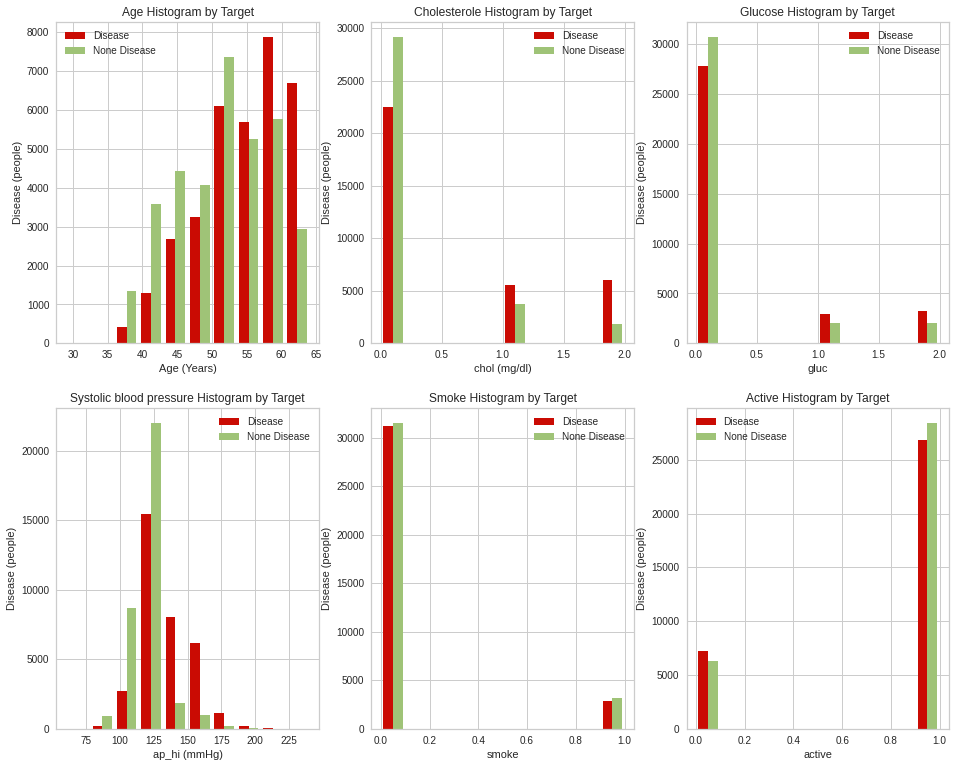

In [ ]:
plt.figure(figsize=[16,13])

plt.subplot(231)
plt.hist(x= [dis_df_new[dis_df_new['cardio'] == 1]['age'],dis_df_new[dis_df_new['cardio'] == 0]['age']],
         stacked = False, color = ['r', 'g'], label = ['Disease','None Disease'])
plt.title('Age Histogram by Target')
plt.xlabel('Age (Years)')
plt.ylabel('Disease (people)')
plt.legend()

plt.subplot(232)
plt.hist(x= [dis_df_new[dis_df_new['cardio'] == 1]['cholesterol'],dis_df_new[dis_df_new['cardio'] == 0]['cholesterol']],
         stacked = False, color = ['r', 'g'], label = ['Disease','None Disease'])
plt.title('Cholesterole Histogram by Target')
plt.xlabel('chol (mg/dl)')
plt.ylabel('Disease (people)')
plt.legend()

plt.subplot(233)
plt.hist(x= [dis_df_new[dis_df_new['cardio'] == 1]['gluc'],dis_df_new[dis_df_new['cardio'] == 0]['gluc']],
         stacked = False, color = ['r', 'g'], label = ['Disease','None Disease'])
plt.title('Glucose Histogram by Target')
plt.xlabel('gluc')
plt.ylabel('Disease (people)')
plt.legend()

plt.subplot(234)
plt.hist(x= [dis_df_new[dis_df_new['cardio'] == 1]['ap_hi'],dis_df_new[dis_df_new['cardio'] == 0]['ap_hi']],
         stacked = False, color = ['r', 'g'], label = ['Disease','None Disease'])
plt.title('Systolic blood pressure Histogram by Target')
plt.xlabel('ap_hi (mmHg)')
plt.ylabel('Disease (people)')
plt.legend()

plt.subplot(235)
plt.hist(x= [dis_df_new[dis_df_new['cardio'] == 1]['smoke'],dis_df_new[dis_df_new['cardio'] == 0]['smoke']],
         stacked = False, color = ['r', 'g'], label = ['Disease','None Disease'])
plt.title('Smoke Histogram by Target')
plt.xlabel('smoke')
plt.ylabel('Disease (people)')
plt.legend()

plt.subplot(236)
plt.hist(x= [dis_df_new[dis_df_new['cardio'] == 1]['active'],dis_df_new[dis_df_new['cardio'] == 0]['active']],
         stacked = False, color = ['r', 'g'], label = ['Disease','None Disease'])
plt.title('Active Histogram by Target')
plt.xlabel('active')
plt.ylabel('Disease (people)')
plt.legend()

In [ ]:
corr = dis_df_new.corr(method = 'pearson')

In [ ]:
corr_column_names = list(dis_df_new.columns)

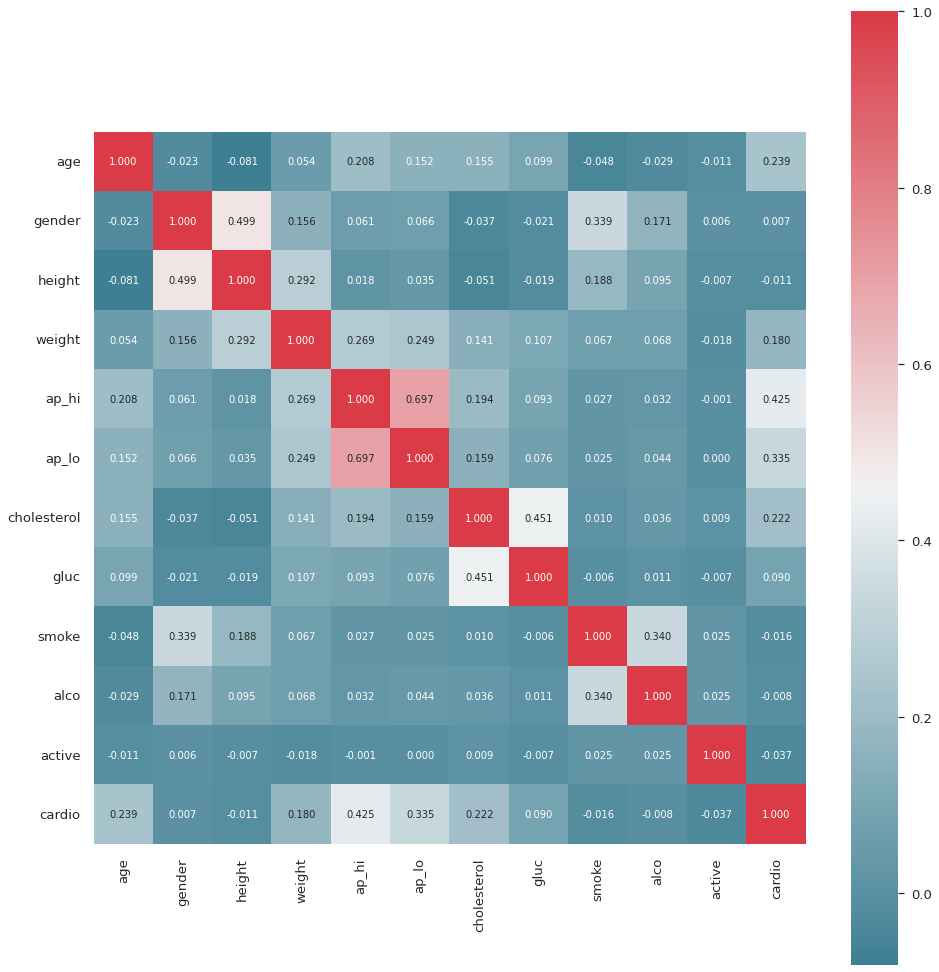

In [ ]:
corr = dis_df_new.corr(method = 'pearson')
colormap = sns.diverging_palette(220, 10, as_cmap = True)

sns.set(font_scale = 1.2, rc = {'figure.figsize' : (14, 14)})
dis_df_heatmap = sns.heatmap(corr.values,
                             cmap = colormap,
                             cbar = True,
                             annot = True,
                             annot_kws = {'size' : 10},
                             fmt = '.3f',
                             square = 'True',
                             yticklabels = corr_column_names,
                             xticklabels = corr_column_names)
plt.tight_layout()
plt.show()

# 기본 결측치 처리만 한 데이터 셋으로 학습

In [ ]:
dis_df_X.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,50,1,168,62.0,110,80,0,0,0,0,1
1,55,0,156,85.0,140,90,2,0,0,0,1
2,51,0,165,64.0,130,70,2,0,0,0,0


In [ ]:
cross_validate_model(dis_df_X, dis_df_y)

,Train Mean ACC,Test Mean ACC,Test ACC 3 * STD,Using Data Name
Model Name,,,,
XGBClassifier,0.7368,0.7353,0.0126,"[dis_df_X, dis_df_y]"
CatBoostClassifier,0.7537,0.7352,0.0081,"[dis_df_X, dis_df_y]"
LGBMClassifier,0.7467,0.7351,0.0092,"[dis_df_X, dis_df_y]"
GradientBoostingClassifier,0.7373,0.7347,0.0114,"[dis_df_X, dis_df_y]"
AdaBoostClassifier,0.7301,0.729,0.0081,"[dis_df_X, dis_df_y]"
LogisticRegressionCV,0.727,0.7272,0.01,"[dis_df_X, dis_df_y]"
RidgeClassifierCV,0.7252,0.725,0.0095,"[dis_df_X, dis_df_y]"
RandomForestClassifier,0.9801,0.7055,0.0108,"[dis_df_X, dis_df_y]"
ExtraTreesClassifier,0.9801,0.6905,0.0141,"[dis_df_X, dis_df_y]"


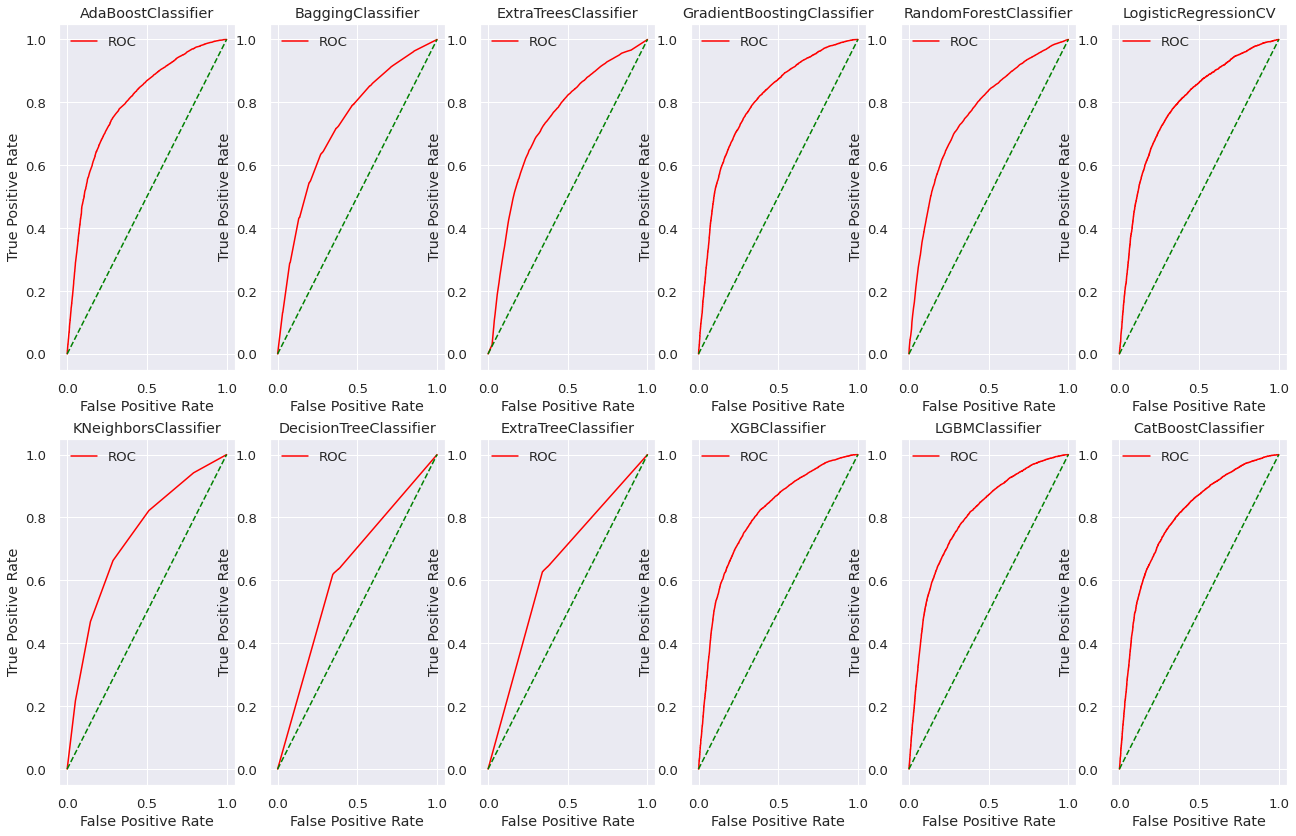

,ROC_AUC_SCORE,Using Data
Model Name,,
GradientBoostingClassifier,0.733763,"[dis_df_X, dis_df_y]"
XGBClassifier,0.733633,"[dis_df_X, dis_df_y]"
LGBMClassifier,0.7331,"[dis_df_X, dis_df_y]"
CatBoostClassifier,0.732511,"[dis_df_X, dis_df_y]"
AdaBoostClassifier,0.729933,"[dis_df_X, dis_df_y]"
LogisticRegressionCV,0.728678,"[dis_df_X, dis_df_y]"
RandomForestClassifier,0.709468,"[dis_df_X, dis_df_y]"
ExtraTreesClassifier,0.694386,"[dis_df_X, dis_df_y]"
KNeighborsClassifier,0.687763,"[dis_df_X, dis_df_y]"


In [ ]:
all_plot_roc_curve(dis_df_X, dis_df_y)

['dis_df_X', 'dis_df_y'] 데이터를 사용한 모델 CatBoostClassifier 의 경우 test_size가 0.17일 때 0.7368의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.17,0.7368
0.24,0.7367
0.23,0.7363
0.38,0.7362
0.20,0.7362


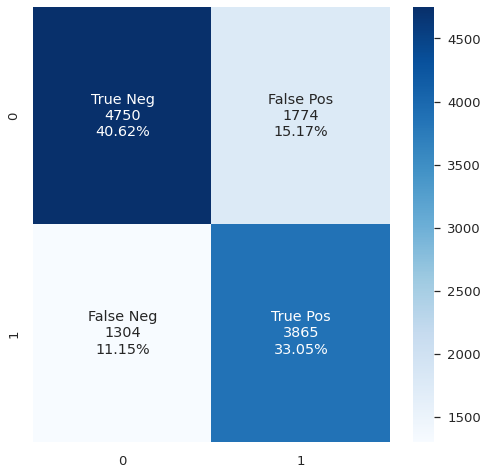

In [ ]:
fit_model_acc(CB_cf, dis_df_X, dis_df_y)

['dis_df_X', 'dis_df_y'] 데이터를 사용한 모델 LGBMClassifier 의 경우 test_size가 0.24일 때 0.7361의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.24,0.7361
0.40,0.7359
0.20,0.7358
0.39,0.7358
0.23,0.7354


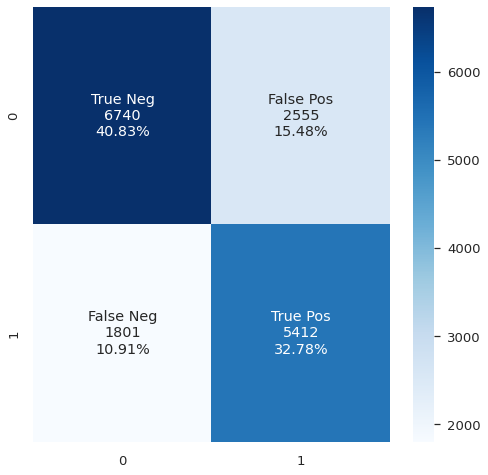

In [ ]:
fit_model_acc(LG_cf, dis_df_X, dis_df_y)

['dis_df_X', 'dis_df_y'] 데이터를 사용한 모델 XGBClassifier 의 경우 test_size가 0.23일 때 0.7374의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.23,0.7374
0.20,0.737
0.37,0.7369
0.39,0.7367
0.38,0.7367


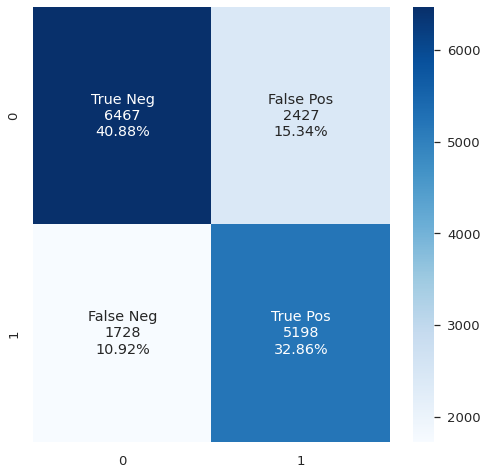

In [ ]:
fit_model_acc(XGB_cf, dis_df_X, dis_df_y)

['dis_df_X', 'dis_df_y'] 데이터를 사용한 모델 GradientBoostingClassifier 의 경우 test_size가 0.2일 때 0.7374의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.39,0.7374
0.20,0.7374
0.38,0.737
0.35,0.7367
0.19,0.7366


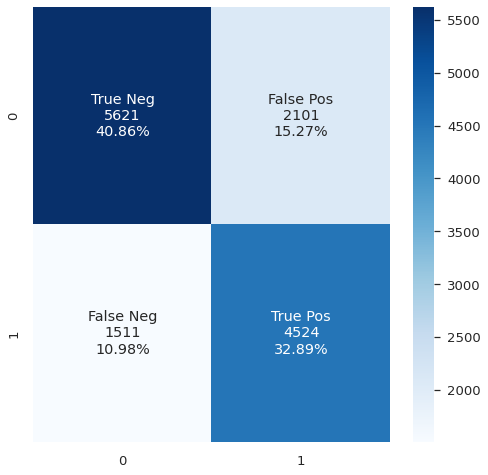

In [ ]:
fit_model_acc(GB_cf, dis_df_X, dis_df_y)

# 연령대 분류 및 연속형 데이터 StandardScaler 실행한 데이터 셋

In [ ]:
dataset_df = dis_df_new.copy()

range = [20,30,40,50,60,70]
dataset_df['age_bin'] = pd.DataFrame(pd.cut(dis_df_new['age'], range))
dataset_df = dataset_df.drop('age', axis = 1)

In [ ]:
dataset_df.groupby(['age_bin']).median()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age_bin,,,,,,,,,,,
"(20, 30]",0.0,167.5,59.0,115.0,75.0,0.0,0.0,0.0,0.0,1.0,0.0
"(30, 40]",0.0,165.0,69.0,120.0,80.0,0.0,0.0,0.0,0.0,1.0,0.0
"(40, 50]",0.0,165.0,71.0,120.0,80.0,0.0,0.0,0.0,0.0,1.0,0.0
"(50, 60]",0.0,164.0,72.0,120.0,80.0,0.0,0.0,0.0,0.0,1.0,1.0
"(60, 70]",0.0,164.0,74.0,130.0,80.0,0.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
le = LabelEncoder()

dataset_df['age_bin'] = le.fit_transform(dataset_df['age_bin'])

dataset_df.head(3)

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_bin
0,1,168,62.0,110,80,0,0,0,0,1,0,2
1,0,156,85.0,140,90,2,0,0,0,1,1,3
2,0,165,64.0,130,70,2,0,0,0,0,1,3


In [ ]:
St_scaler = StandardScaler()

dataset_df['height'] = St_scaler.fit_transform(np.array(dataset_df['height']).reshape(-1,1))
dataset_df['weight'] = St_scaler.fit_transform(np.array(dataset_df['weight']).reshape(-1,1))
dataset_df['ap_hi'] = St_scaler.fit_transform(np.array(dataset_df['ap_hi']).reshape(-1,1))
dataset_df['ap_lo'] = St_scaler.fit_transform(np.array(dataset_df['ap_lo']).reshape(-1,1))

dataset_df.head(3)

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_bin
0,1,0.444513,-0.845921,-0.991163,-0.142188,0,0,0,0,1,0,2
1,0,-1.021593,0.758977,0.798448,0.889986,2,0,0,0,1,1,3
2,0,0.077987,-0.706365,0.201911,-1.174362,2,0,0,0,0,1,3


In [ ]:
dataset_df_y = dataset_df['cardio']
dataset_df_X = dataset_df.drop('cardio', axis = 1)

# 연령대 분류 및 연속형 데이터 StandardScaler 실행한 데이터 셋으로 학습 실시

In [ ]:
dataset_df_X.head(3)

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_bin
0,1,0.444513,-0.845921,-0.991163,-0.142188,0,0,0,0,1,2
1,0,-1.021593,0.758977,0.798448,0.889986,2,0,0,0,1,3
2,0,0.077987,-0.706365,0.201911,-1.174362,2,0,0,0,0,3


In [ ]:
cross_validate_model(dataset_df_X, dataset_df_y)

,Train Mean ACC,Test Mean ACC,Test ACC 3 * STD,Using Data Name
Model Name,,,,
GradientBoostingClassifier,0.7355,0.733,0.0123,"[dataset_df_X, dataset_df_y]"
CatBoostClassifier,0.7497,0.7329,0.0109,"[dataset_df_X, dataset_df_y]"
XGBClassifier,0.7354,0.7327,0.0104,"[dataset_df_X, dataset_df_y]"
LGBMClassifier,0.7439,0.7327,0.0093,"[dataset_df_X, dataset_df_y]"
AdaBoostClassifier,0.7287,0.7285,0.0118,"[dataset_df_X, dataset_df_y]"
LogisticRegressionCV,0.7272,0.7271,0.0125,"[dataset_df_X, dataset_df_y]"
RidgeClassifierCV,0.7257,0.7256,0.0104,"[dataset_df_X, dataset_df_y]"
SGDClassifier,0.7193,0.7211,0.0309,"[dataset_df_X, dataset_df_y]"
KNeighborsClassifier,0.7789,0.6956,0.0094,"[dataset_df_X, dataset_df_y]"


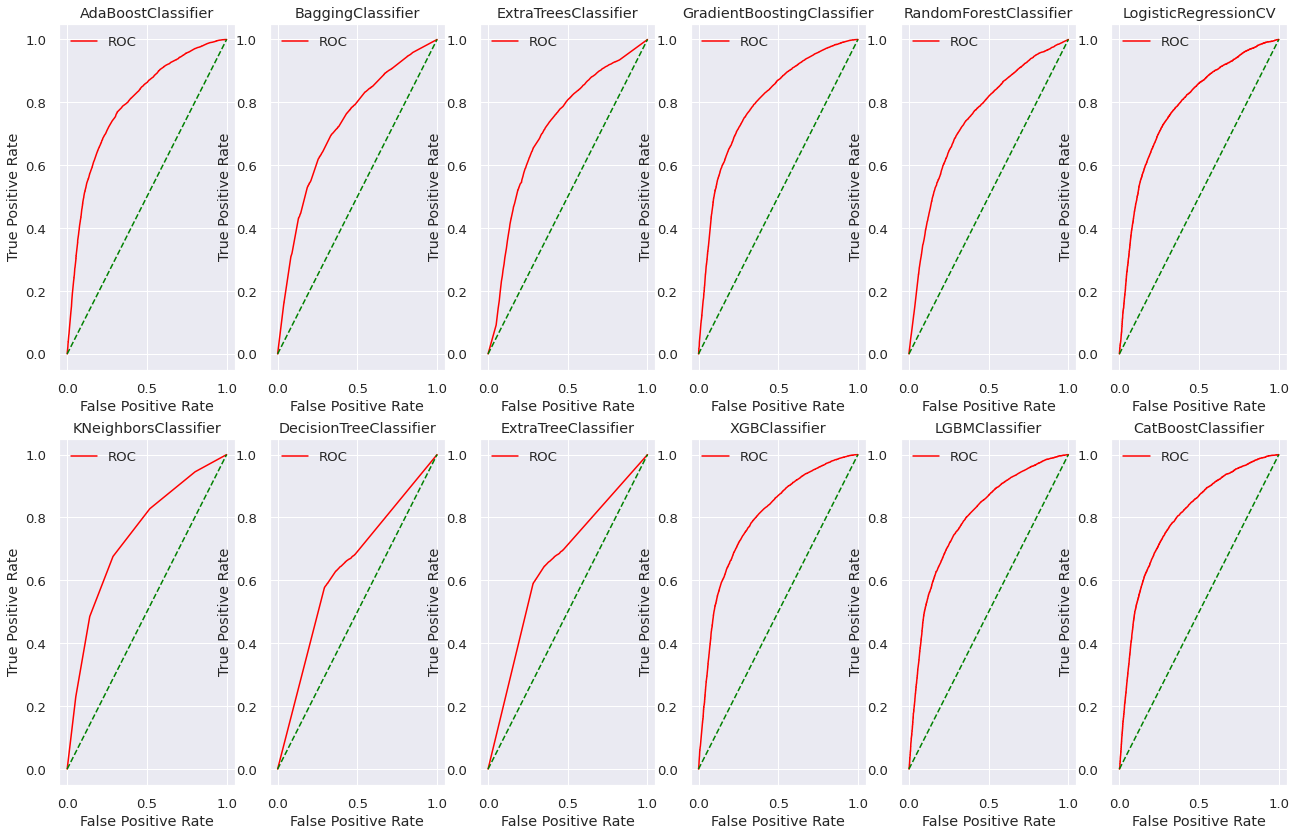

,ROC_AUC_SCORE,Using Data
Model Name,,
CatBoostClassifier,0.732899,"[dataset_df_X, dataset_df_y]"
GradientBoostingClassifier,0.732544,"[dataset_df_X, dataset_df_y]"
XGBClassifier,0.732407,"[dataset_df_X, dataset_df_y]"
LGBMClassifier,0.730077,"[dataset_df_X, dataset_df_y]"
AdaBoostClassifier,0.726695,"[dataset_df_X, dataset_df_y]"
LogisticRegressionCV,0.724433,"[dataset_df_X, dataset_df_y]"
RandomForestClassifier,0.698408,"[dataset_df_X, dataset_df_y]"
KNeighborsClassifier,0.694318,"[dataset_df_X, dataset_df_y]"
ExtraTreesClassifier,0.685466,"[dataset_df_X, dataset_df_y]"


In [ ]:
all_plot_roc_curve(dataset_df_X, dataset_df_y)

['dataset_df_X', 'dataset_df_y'] 데이터를 사용한 모델 CatBoostClassifier 의 경우 test_size가 0.38일 때 0.7364의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.38,0.7364
0.39,0.7357
0.40,0.7352
0.36,0.735
0.37,0.735


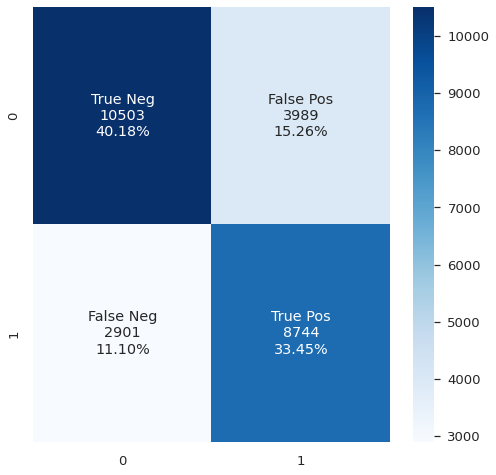

In [ ]:
fit_model_acc(CB_cf, dataset_df_X, dataset_df_y)

['dataset_df_X', 'dataset_df_y'] 데이터를 사용한 모델 LGBMClassifier 의 경우 test_size가 0.39일 때 0.7357의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.39,0.7357
0.40,0.7355
0.37,0.7352
0.17,0.7347
0.38,0.7345


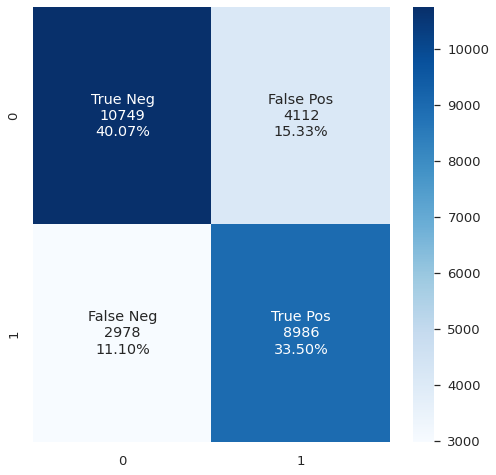

In [ ]:
fit_model_acc(LG_cf, dataset_df_X, dataset_df_y)

['dataset_df_X', 'dataset_df_y'] 데이터를 사용한 모델 XGBClassifier 의 경우 test_size가 0.38일 때 0.7367의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.38,0.7367
0.39,0.7359
0.36,0.7356
0.40,0.7355
0.37,0.7355


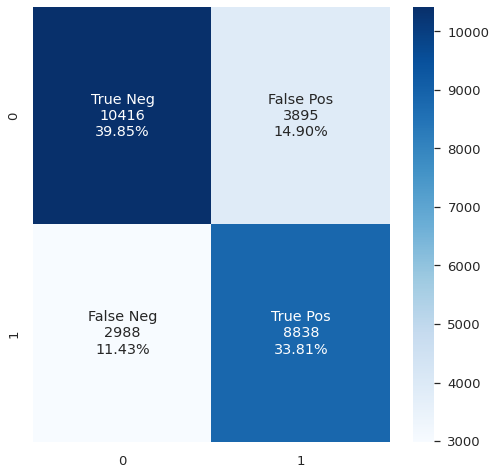

In [ ]:
fit_model_acc(XGB_cf, dataset_df_X, dataset_df_y)

['dataset_df_X', 'dataset_df_y'] 데이터를 사용한 모델 GradientBoostingClassifier 의 경우 test_size가 0.38일 때 0.7361의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.38,0.7361
0.35,0.7355
0.37,0.7354
0.34,0.7351
0.39,0.735


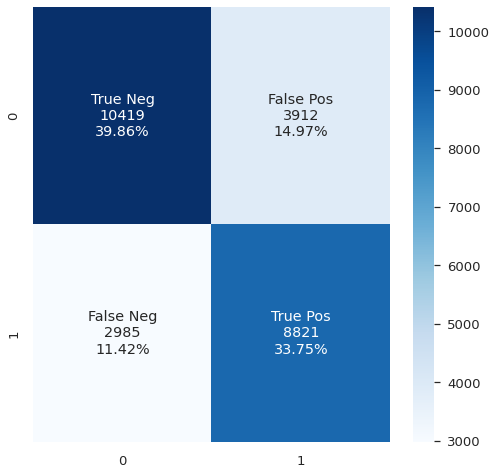

In [ ]:
fit_model_acc(GB_cf, dataset_df_X, dataset_df_y)

# 결측치만 제거한 데이터에서 최고혈압/최저혈압에 가중치 부여 후 30% 랜덤추출 

In [ ]:
dataset_sample_df = dis_df_new.sample(frac = 0.3,  weights='ap_hi', random_state = 2)

In [ ]:
dataset_sample_df_aplo = dis_df_new.sample(frac = 0.3,  weights='ap_lo', random_state = 2)

In [ ]:
range = [20,30,40,50,60,70]
dataset_sample_df['age_bin'] = pd.DataFrame(pd.cut(dataset_sample_df['age'], range))
dataset_sample_df = dataset_sample_df.drop('age', axis = 1)
dataset_sample_df['age_bin'] = le.fit_transform(dataset_sample_df['age_bin'])

dataset_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20634 entries, 30530 to 28154
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       20634 non-null  int64  
 1   height       20634 non-null  int64  
 2   weight       20634 non-null  float64
 3   ap_hi        20634 non-null  int64  
 4   ap_lo        20634 non-null  int64  
 5   cholesterol  20634 non-null  int64  
 6   gluc         20634 non-null  int64  
 7   smoke        20634 non-null  int64  
 8   alco         20634 non-null  int64  
 9   active       20634 non-null  int64  
 10  cardio       20634 non-null  int64  
 11  age_bin      20634 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.0 MB


In [ ]:
range = [20,30,40,50,60,70]
dataset_sample_df_aplo['age_bin'] = pd.DataFrame(pd.cut(dataset_sample_df_aplo['age'], range))
dataset_sample_df_aplo = dataset_sample_df_aplo.drop('age', axis = 1)
dataset_sample_df_aplo['age_bin'] = le.fit_transform(dataset_sample_df_aplo['age_bin'])

dataset_sample_df_aplo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20634 entries, 30528 to 58096
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       20634 non-null  int64  
 1   height       20634 non-null  int64  
 2   weight       20634 non-null  float64
 3   ap_hi        20634 non-null  int64  
 4   ap_lo        20634 non-null  int64  
 5   cholesterol  20634 non-null  int64  
 6   gluc         20634 non-null  int64  
 7   smoke        20634 non-null  int64  
 8   alco         20634 non-null  int64  
 9   active       20634 non-null  int64  
 10  cardio       20634 non-null  int64  
 11  age_bin      20634 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.0 MB


In [ ]:
dataset_sample_df['height'] = St_scaler.fit_transform(np.array(dataset_sample_df['height']).reshape(-1,1))
dataset_sample_df['weight'] = St_scaler.fit_transform(np.array(dataset_sample_df['weight']).reshape(-1,1))
dataset_sample_df['ap_hi'] = St_scaler.fit_transform(np.array(dataset_sample_df['ap_hi']).reshape(-1,1))
dataset_sample_df['ap_lo'] = St_scaler.fit_transform(np.array(dataset_sample_df['ap_lo']).reshape(-1,1))

In [ ]:
dataset_sample_df_aplo['height'] = St_scaler.fit_transform(np.array(dataset_sample_df_aplo['height']).reshape(-1,1))
dataset_sample_df_aplo['weight'] = St_scaler.fit_transform(np.array(dataset_sample_df_aplo['weight']).reshape(-1,1))
dataset_sample_df_aplo['ap_hi'] = St_scaler.fit_transform(np.array(dataset_sample_df_aplo['ap_hi']).reshape(-1,1))
dataset_sample_df_aplo['ap_lo'] = St_scaler.fit_transform(np.array(dataset_sample_df_aplo['ap_lo']).reshape(-1,1))

In [ ]:
dataset_sample_df.describe()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_bin
count,20634.000000,2.063400e+04,2.063400e+04,2.063400e+04,2.063400e+04,20634.000000,20634.000000,20634.000000,20634.000000,20634.000000,20634.000000,20634.000000
mean,0.351895,-2.796165e-16,5.695637e-16,-4.697006e-16,4.304441e-16,0.378114,0.226519,0.088252,0.055152,0.802365,0.515993,2.759475
std,0.477573,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,0.687558,0.572189,0.283668,0.228282,0.398225,0.499756,0.752684
min,0.000000,-1.322567e+01,-4.371554e+00,-2.773990e+00,-5.288413e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-6.560415e-01,-6.530013e-01,-4.836572e-01,-2.164188e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,0.000000,6.912913e-02,-1.709667e-01,-4.836572e-01,-2.164188e-01,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000
75%,1.000000,6.734380e-01,5.176541e-01,6.615093e-01,7.979799e-01,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000
max,1.000000,1.034238e+01,8.643380e+00,6.387341e+00,1.094197e+01,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [ ]:
sample_df_X = dataset_sample_df.drop('cardio', axis = 1)
sample_df_y = dataset_sample_df['cardio']

In [ ]:
sample_df_X_aplo = dataset_sample_df_aplo.drop('cardio', axis = 1)
sample_df_y_aplo = dataset_sample_df_aplo['cardio']

# 결측치만 제거한 데이터에서 최고혈압/최저혈압에 가중치 부여 후 30% 랜덤추출 데이터셋 학습

In [ ]:
sample_df_X.head(3)

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_bin
30530,0,-1.018627,0.517654,-0.483657,-0.317859,0,0,0,0,1,4
1815,0,-0.293456,-0.446415,0.661509,0.797980,0,0,0,0,1,2
38468,1,0.794300,0.586516,0.661509,0.797980,0,0,0,0,1,3


In [ ]:
sample_df_X_aplo.head(3)

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_bin
30528,1,0.674982,-0.318341,-0.45342,-0.230370,1,0,0,1,1,3
1815,0,-0.299281,-0.455559,0.71491,0.787238,0,0,0,0,1,2
38471,0,-0.542847,-1.073041,-0.45342,-0.230370,0,0,0,0,1,3


In [ ]:
cross_validate_model(sample_df_X, sample_df_y)

,Train Mean ACC,Test Mean ACC,Test ACC 3 * STD,Using Data Name
Model Name,,,,
XGBClassifier,0.7412,0.7357,0.0151,"[sample_df_X, sample_df_y]"
GradientBoostingClassifier,0.7426,0.7354,0.0129,"[sample_df_X, sample_df_y]"
CatBoostClassifier,0.7662,0.7348,0.0167,"[sample_df_X, sample_df_y]"
LGBMClassifier,0.7635,0.7316,0.012,"[sample_df_X, sample_df_y]"
AdaBoostClassifier,0.7325,0.7303,0.0189,"[sample_df_X, sample_df_y]"
LogisticRegressionCV,0.7305,0.7299,0.0157,"[sample_df_X, sample_df_y]"
RidgeClassifierCV,0.7283,0.7287,0.02,"[sample_df_X, sample_df_y]"
SGDClassifier,0.7203,0.7214,0.0266,"[sample_df_X, sample_df_y]"
KNeighborsClassifier,0.7856,0.7019,0.0114,"[sample_df_X, sample_df_y]"


In [ ]:
cross_validate_model(sample_df_X_aplo, sample_df_y_aplo)

,Train Mean ACC,Test Mean ACC,Test ACC 3 * STD,Using Data Name
Model Name,,,,
GradientBoostingClassifier,0.7431,0.736,0.0116,"[sample_df_X_aplo, sample_df_y_aplo]"
XGBClassifier,0.7425,0.7356,0.0093,"[sample_df_X_aplo, sample_df_y_aplo]"
CatBoostClassifier,0.7668,0.7347,0.0065,"[sample_df_X_aplo, sample_df_y_aplo]"
LGBMClassifier,0.7641,0.7338,0.0123,"[sample_df_X_aplo, sample_df_y_aplo]"
AdaBoostClassifier,0.7329,0.7327,0.0075,"[sample_df_X_aplo, sample_df_y_aplo]"
LogisticRegressionCV,0.7313,0.7298,0.0097,"[sample_df_X_aplo, sample_df_y_aplo]"
RidgeClassifierCV,0.7293,0.7288,0.0125,"[sample_df_X_aplo, sample_df_y_aplo]"
SGDClassifier,0.7207,0.7189,0.0488,"[sample_df_X_aplo, sample_df_y_aplo]"
RandomForestClassifier,0.9656,0.7,0.0154,"[sample_df_X_aplo, sample_df_y_aplo]"


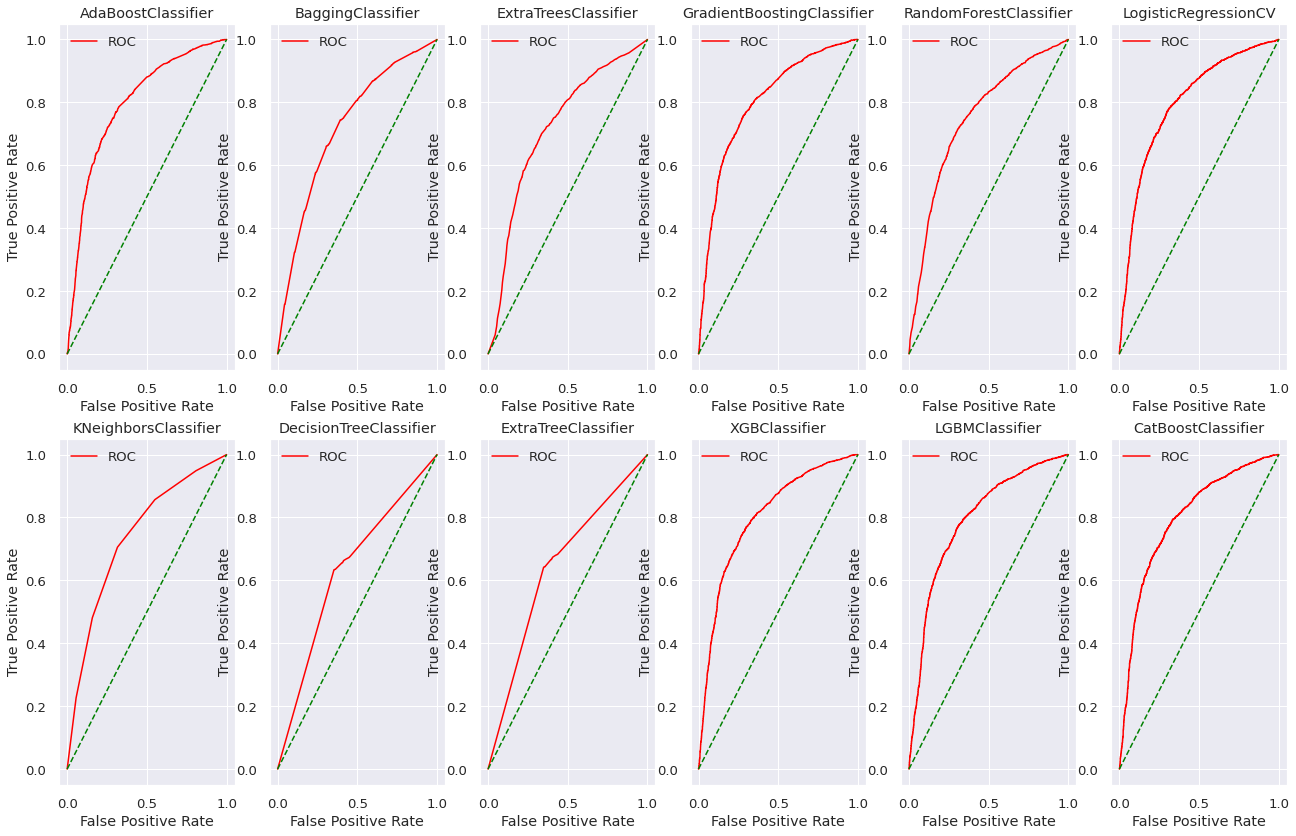

,ROC_AUC_SCORE,Using Data
Model Name,,
GradientBoostingClassifier,0.735703,"[sample_df_X, sample_df_y]"
XGBClassifier,0.734248,"[sample_df_X, sample_df_y]"
AdaBoostClassifier,0.731865,"[sample_df_X, sample_df_y]"
LogisticRegressionCV,0.731805,"[sample_df_X, sample_df_y]"
CatBoostClassifier,0.728952,"[sample_df_X, sample_df_y]"
LGBMClassifier,0.72858,"[sample_df_X, sample_df_y]"
RandomForestClassifier,0.699807,"[sample_df_X, sample_df_y]"
KNeighborsClassifier,0.695041,"[sample_df_X, sample_df_y]"
ExtraTreesClassifier,0.682316,"[sample_df_X, sample_df_y]"


In [ ]:
all_plot_roc_curve(sample_df_X, sample_df_y)

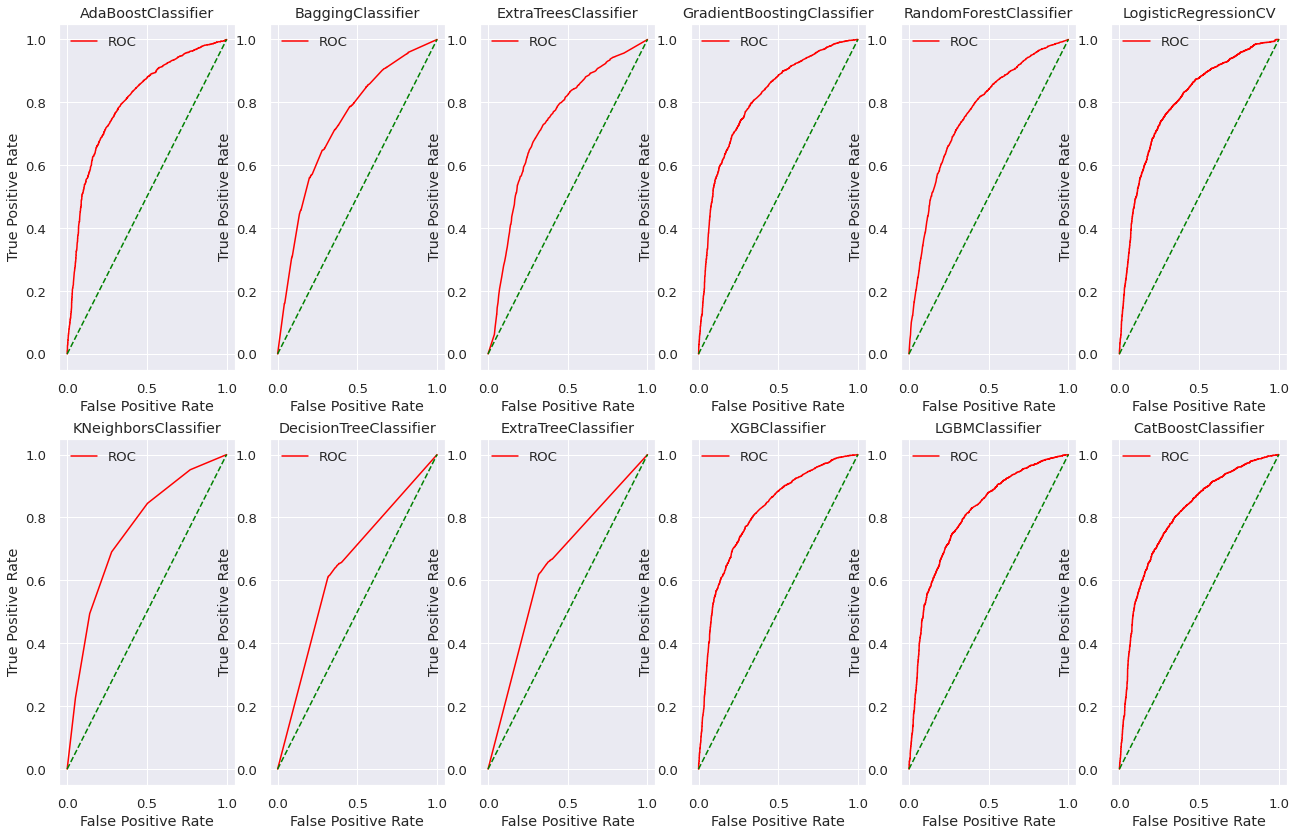

,ROC_AUC_SCORE,Using Data
Model Name,,
XGBClassifier,0.739404,"[sample_df_X_aplo, sample_df_y_aplo]"
LogisticRegressionCV,0.739362,"[sample_df_X_aplo, sample_df_y_aplo]"
GradientBoostingClassifier,0.7387,"[sample_df_X_aplo, sample_df_y_aplo]"
LGBMClassifier,0.737745,"[sample_df_X_aplo, sample_df_y_aplo]"
CatBoostClassifier,0.736017,"[sample_df_X_aplo, sample_df_y_aplo]"
AdaBoostClassifier,0.735737,"[sample_df_X_aplo, sample_df_y_aplo]"
RandomForestClassifier,0.707524,"[sample_df_X_aplo, sample_df_y_aplo]"
KNeighborsClassifier,0.705826,"[sample_df_X_aplo, sample_df_y_aplo]"
ExtraTreesClassifier,0.69454,"[sample_df_X_aplo, sample_df_y_aplo]"


In [ ]:
all_plot_roc_curve(sample_df_X_aplo, sample_df_y_aplo)

['sample_df_X', 'sample_df_y'] 데이터를 사용한 모델 CatBoostClassifier 의 경우 test_size가 0.31일 때 0.7346의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.36,0.7346
0.31,0.7346
0.23,0.7343
0.30,0.7338
0.34,0.7338


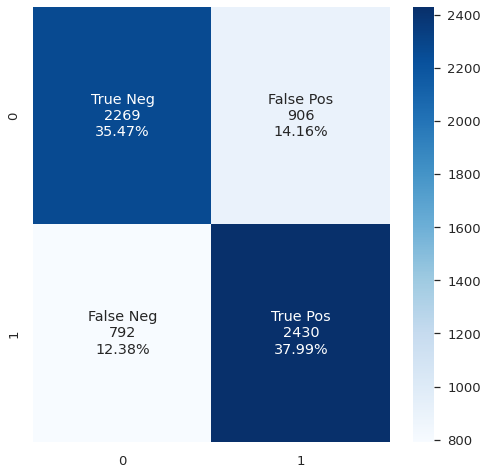

In [ ]:
fit_model_acc(CB_cf, sample_df_X, sample_df_y)

['sample_df_X', 'sample_df_y'] 데이터를 사용한 모델 LGBMClassifier 의 경우 test_size가 0.15일 때 0.7335의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.15,0.7335
0.22,0.7328
0.32,0.7327
0.31,0.7322
0.39,0.7319


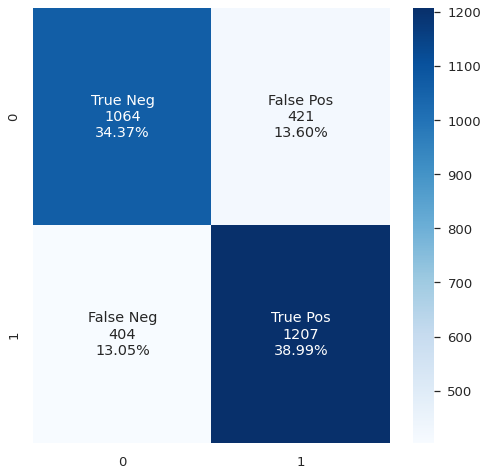

In [ ]:
fit_model_acc(LG_cf, sample_df_X, sample_df_y)

['sample_df_X', 'sample_df_y'] 데이터를 사용한 모델 XGBClassifier 의 경우 test_size가 0.4일 때 0.7395의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.40,0.7395
0.28,0.7388
0.31,0.7382
0.30,0.7377
0.32,0.7374


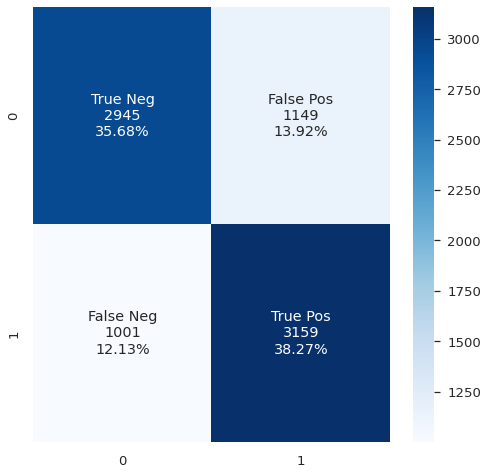

In [ ]:
fit_model_acc(XGB_cf, sample_df_X, sample_df_y)

['sample_df_X', 'sample_df_y'] 데이터를 사용한 모델 GradientBoostingClassifier 의 경우 test_size가 0.29일 때 0.7378의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.29,0.7378
0.40,0.7372
0.37,0.7371
0.27,0.7371
0.31,0.7369


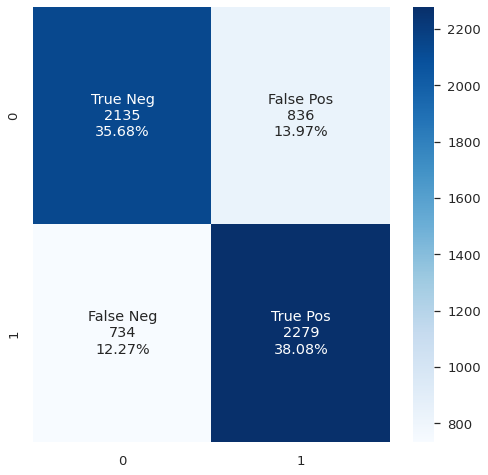

In [ ]:
fit_model_acc(GB_cf, sample_df_X, sample_df_y)

['sample_df_X_aplo', 'sample_df_y_aplo'] 데이터를 사용한 모델 XGBClassifier 의 경우 test_size가 0.24일 때 0.7426의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.24,0.7426
0.23,0.7408
0.26,0.739
0.20,0.7388
0.25,0.7385


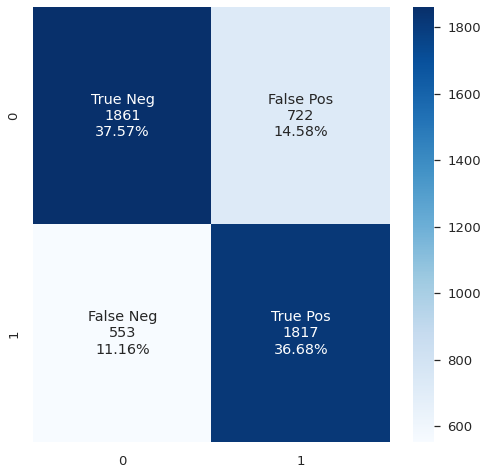

In [ ]:
fit_model_acc(XGB_cf, sample_df_X_aplo, sample_df_y_aplo)

['sample_df_X_aplo', 'sample_df_y_aplo'] 데이터를 사용한 모델 GradientBoostingClassifier 의 경우 test_size가 0.24일 때 0.742의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.24,0.742
0.23,0.7419
0.28,0.7385
0.22,0.7385
0.31,0.7383


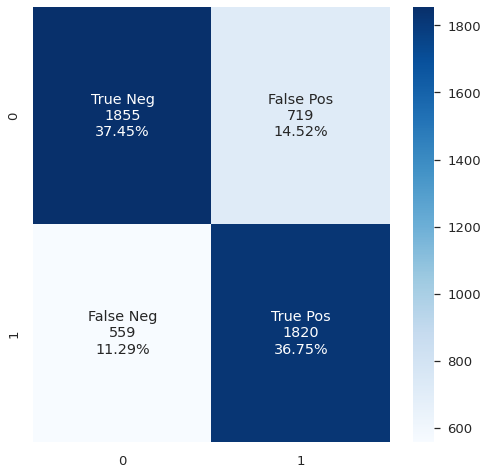

In [ ]:
fit_model_acc(GB_cf, sample_df_X_aplo, sample_df_y_aplo)

['sample_df_X_aplo', 'sample_df_y_aplo'] 데이터를 사용한 모델 CatBoostClassifier 의 경우 test_size가 0.23일 때 0.741의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.15,0.741
0.23,0.741
0.24,0.7408
0.20,0.7405
0.21,0.7393


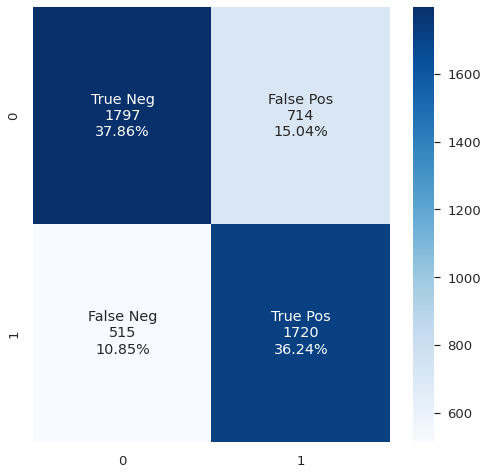

In [ ]:
fit_model_acc(CB_cf, sample_df_X_aplo, sample_df_y_aplo)

['sample_df_X_aplo', 'sample_df_y_aplo'] 데이터를 사용한 모델 LGBMClassifier 의 경우 test_size가 0.24일 때 0.7412의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.24,0.7412
0.22,0.739
0.17,0.7386
0.23,0.7385
0.21,0.7372


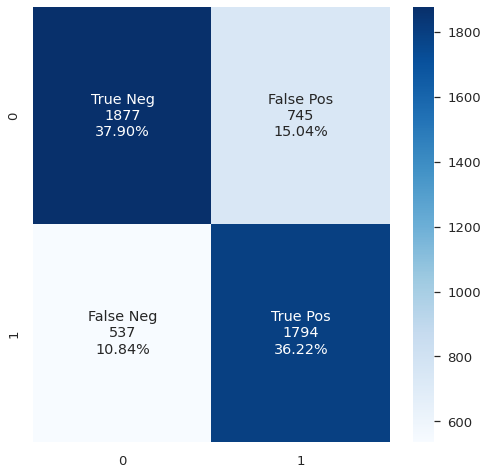

In [ ]:
fit_model_acc(LG_cf, sample_df_X_aplo, sample_df_y_aplo)

['sample_df_X_aplo', 'sample_df_y_aplo'] 데이터를 사용한 모델 LogisticRegressionCV 의 경우 test_size가 0.24일 때 0.7406의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.24,0.7406
0.23,0.7383
0.25,0.7377
0.22,0.7361
0.30,0.7346


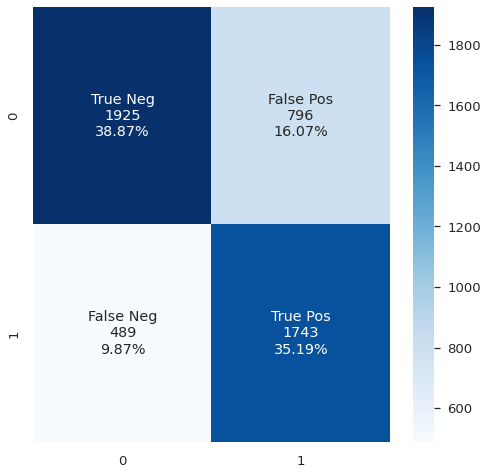

In [ ]:
fit_model_acc(LR_cv, sample_df_X_aplo, sample_df_y_aplo)

# 최고혈압 / 최저혈압 가증치 부가 후 30% 랜덤 추출 + disease 컬럼 추가

In [ ]:
sample_df_2 = dis_df_new.sample(frac = 0.3,  weights='ap_hi', random_state = 2)

In [ ]:
sample_df_4 = dis_df_new.sample(frac = 0.3,  weights='ap_lo', random_state = 2)

In [ ]:
A = sample_df_2[(sample_df_2['cholesterol'] != 0) | (sample_df_2['gluc'] != 0) 
| (sample_df_2['smoke'] != 0) | (sample_df_2['ap_hi'] >= 140)].index

In [ ]:
A = sample_df_4[(sample_df_4['cholesterol'] != 0) | (sample_df_4['gluc'] != 0) 
| (sample_df_4['smoke'] != 0) | (sample_df_4['ap_hi'] >= 140)].index

In [ ]:
for i in A:
  sample_df_2.loc[i,['disease']] = 1

In [ ]:
for i in A:
  sample_df_4.loc[i,['disease']] = 1

In [ ]:
sample_df_2 = sample_df_2.fillna(0)

In [ ]:
sample_df_4 = sample_df_4.fillna(0)

In [ ]:
sample_df2_X = sample_df_2.drop('cardio', axis = 1)
sample_df2_y = sample_df_2['cardio']

In [ ]:
sample_df4_X = sample_df_4.drop('cardio', axis = 1)
sample_df4_y = sample_df_4['cardio']

# 최고혈압 / 최저혈압 가증치 부가 후 30% 랜덤 추출 + disease 컬럼 추가 데이터 학습

In [ ]:
sample_df2_X.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,disease
30530,61,0,156,82.0,120,79,0,0,0,0,1,0.0
1815,41,0,162,68.0,140,90,0,0,0,0,1,1.0
38468,57,1,171,83.0,140,90,0,0,0,0,1,1.0


In [ ]:
sample_df4_X.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,disease
30528,56,1,170,70.0,120,80,1,0,0,1,1,1.0
1815,41,0,162,68.0,140,90,0,0,0,0,1,1.0
38471,53,0,160,59.0,120,80,0,0,0,0,1,0.0


In [ ]:
cross_validate_model(sample_df2_X, sample_df2_y)

,Train Mean ACC,Test Mean ACC,Test ACC 3 * STD,Using Data Name
Model Name,,,,
GradientBoostingClassifier,0.7437,0.7379,0.0324,"[sample_df2_X, sample_df2_y]"
XGBClassifier,0.7428,0.7379,0.0335,"[sample_df2_X, sample_df2_y]"
LGBMClassifier,0.7614,0.7366,0.03,"[sample_df2_X, sample_df2_y]"
CatBoostClassifier,0.7675,0.7355,0.0337,"[sample_df2_X, sample_df2_y]"
AdaBoostClassifier,0.7331,0.7309,0.0318,"[sample_df2_X, sample_df2_y]"
LogisticRegressionCV,0.7307,0.7292,0.0316,"[sample_df2_X, sample_df2_y]"
RidgeClassifierCV,0.7258,0.7255,0.0295,"[sample_df2_X, sample_df2_y]"
RandomForestClassifier,0.9893,0.7087,0.0312,"[sample_df2_X, sample_df2_y]"
ExtraTreesClassifier,0.9894,0.6977,0.0214,"[sample_df2_X, sample_df2_y]"


In [ ]:
cross_validate_model(sample_df4_X, sample_df4_y)

,Train Mean ACC,Test Mean ACC,Test ACC 3 * STD,Using Data Name
Model Name,,,,
GradientBoostingClassifier,0.7457,0.7374,0.01,"[sample_df4_X, sample_df4_y]"
XGBClassifier,0.7447,0.7371,0.0099,"[sample_df4_X, sample_df4_y]"
CatBoostClassifier,0.7725,0.7359,0.0058,"[sample_df4_X, sample_df4_y]"
LGBMClassifier,0.7685,0.7346,0.0074,"[sample_df4_X, sample_df4_y]"
AdaBoostClassifier,0.734,0.7316,0.0081,"[sample_df4_X, sample_df4_y]"
LogisticRegressionCV,0.7298,0.7292,0.0081,"[sample_df4_X, sample_df4_y]"
RidgeClassifierCV,0.7228,0.7229,0.012,"[sample_df4_X, sample_df4_y]"
RandomForestClassifier,0.992,0.7149,0.0168,"[sample_df4_X, sample_df4_y]"
ExtraTreesClassifier,0.992,0.7,0.0185,"[sample_df4_X, sample_df4_y]"


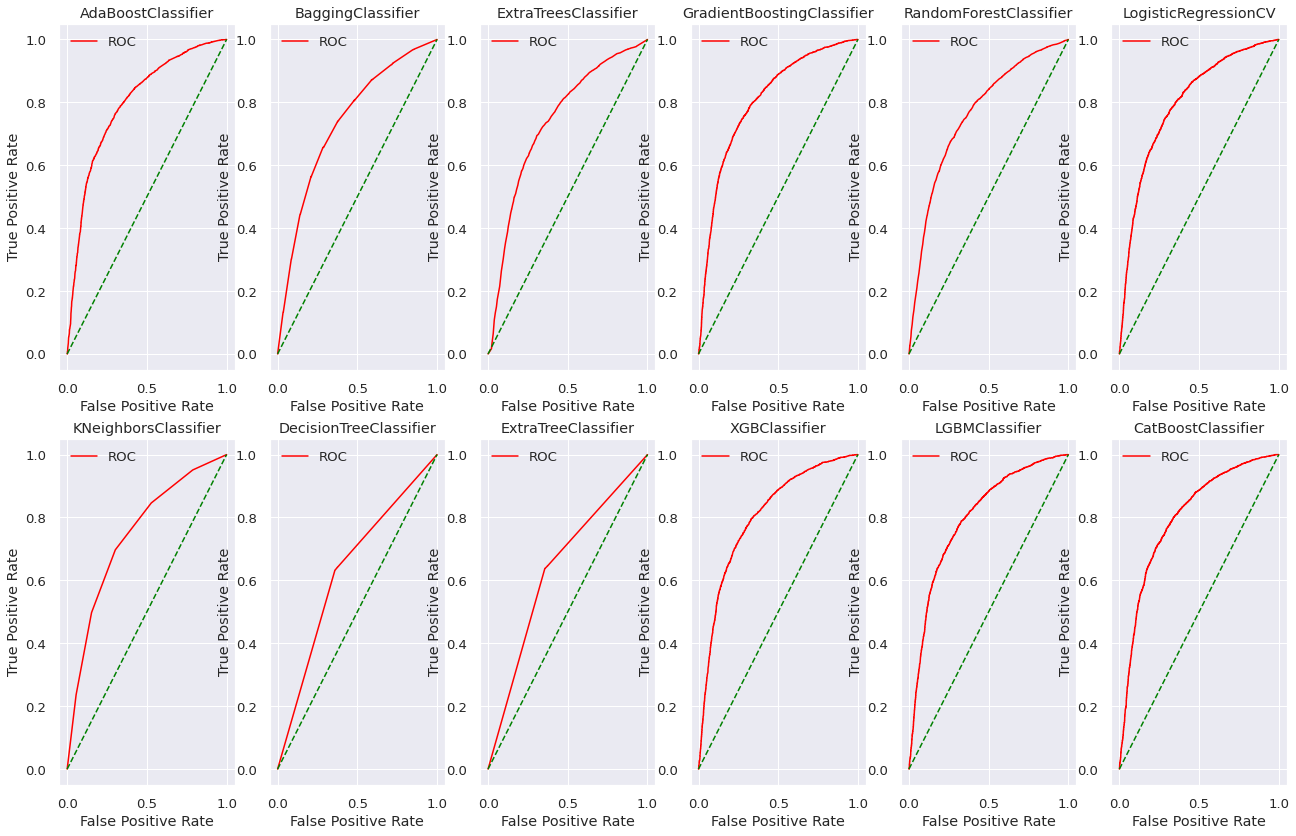

,ROC_AUC_SCORE,Using Data
Model Name,,
GradientBoostingClassifier,0.737941,"[sample_df2_X, sample_df2_y]"
XGBClassifier,0.73645,"[sample_df2_X, sample_df2_y]"
CatBoostClassifier,0.734457,"[sample_df2_X, sample_df2_y]"
LGBMClassifier,0.73159,"[sample_df2_X, sample_df2_y]"
AdaBoostClassifier,0.729506,"[sample_df2_X, sample_df2_y]"
LogisticRegressionCV,0.727602,"[sample_df2_X, sample_df2_y]"
RandomForestClassifier,0.702893,"[sample_df2_X, sample_df2_y]"
KNeighborsClassifier,0.6976,"[sample_df2_X, sample_df2_y]"
ExtraTreesClassifier,0.691313,"[sample_df2_X, sample_df2_y]"


In [ ]:
all_plot_roc_curve(sample_df2_X, sample_df2_y)

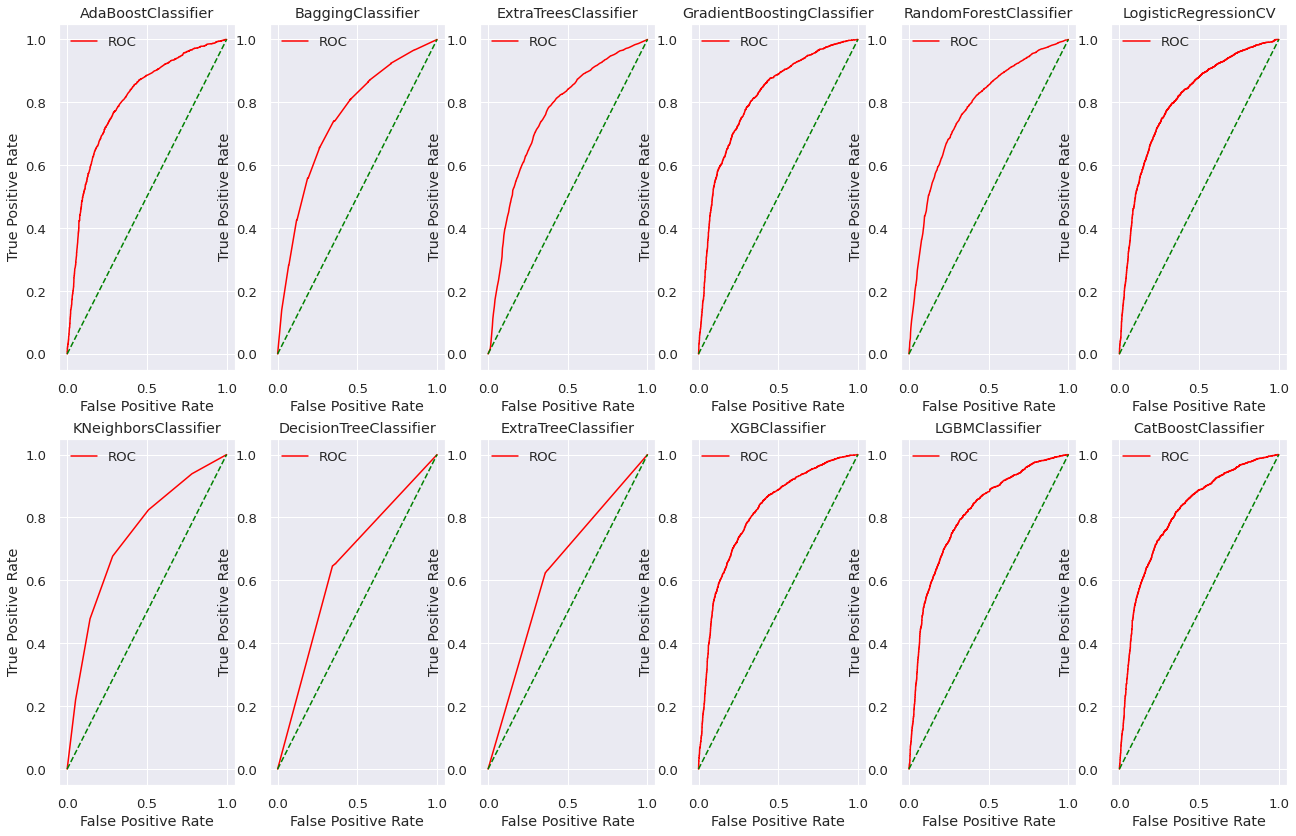

,ROC_AUC_SCORE,Using Data
Model Name,,
CatBoostClassifier,0.743331,"[sample_df4_X, sample_df4_y]"
XGBClassifier,0.741546,"[sample_df4_X, sample_df4_y]"
GradientBoostingClassifier,0.73964,"[sample_df4_X, sample_df4_y]"
LGBMClassifier,0.739018,"[sample_df4_X, sample_df4_y]"
AdaBoostClassifier,0.738315,"[sample_df4_X, sample_df4_y]"
LogisticRegressionCV,0.737009,"[sample_df4_X, sample_df4_y]"
RandomForestClassifier,0.716391,"[sample_df4_X, sample_df4_y]"
ExtraTreesClassifier,0.704915,"[sample_df4_X, sample_df4_y]"
BaggingClassifier,0.696272,"[sample_df4_X, sample_df4_y]"


In [ ]:
all_plot_roc_curve(sample_df4_X, sample_df4_y)

['sample_df2_X', 'sample_df2_y'] 데이터를 사용한 모델 GradientBoostingClassifier 의 경우 test_size가 0.16일 때 0.7385의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.16,0.7385
0.18,0.7381
0.25,0.7376
0.26,0.7368
0.19,0.7366


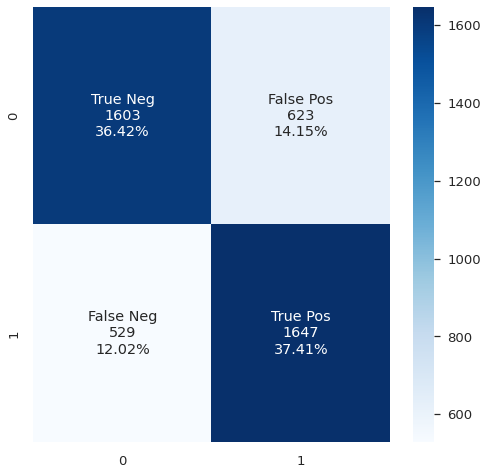

In [ ]:
fit_model_acc(GB_cf, sample_df2_X, sample_df2_y)

['sample_df2_X', 'sample_df2_y'] 데이터를 사용한 모델 XGBClassifier 의 경우 test_size가 0.18일 때 0.7406의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.18,0.7406
0.16,0.7385
0.40,0.7383
0.15,0.7381
0.19,0.7376


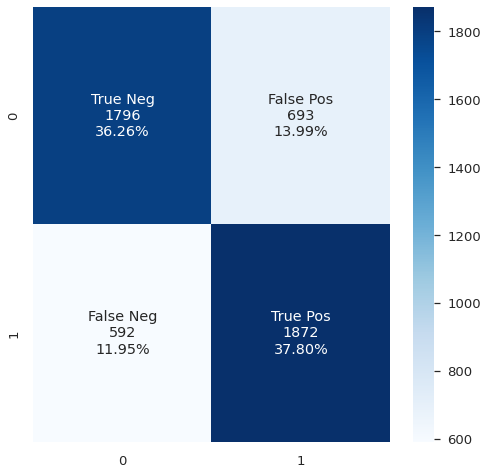

In [ ]:
fit_model_acc(XGB_cf, sample_df2_X, sample_df2_y)

['sample_df2_X', 'sample_df2_y'] 데이터를 사용한 모델 CatBoostClassifier 의 경우 test_size가 0.16일 때 0.736의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.16,0.736
0.38,0.7345
0.40,0.7341
0.25,0.7341
0.37,0.7339


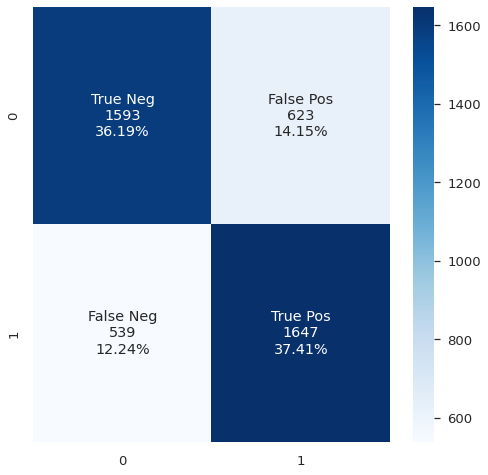

In [ ]:
fit_model_acc(CB_cf, sample_df2_X, sample_df2_y)

['sample_df2_X', 'sample_df2_y'] 데이터를 사용한 모델 LGBMClassifier 의 경우 test_size가 0.16일 때 0.7347의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.16,0.7347
0.15,0.7342
0.17,0.7339
0.18,0.7339
0.39,0.7335


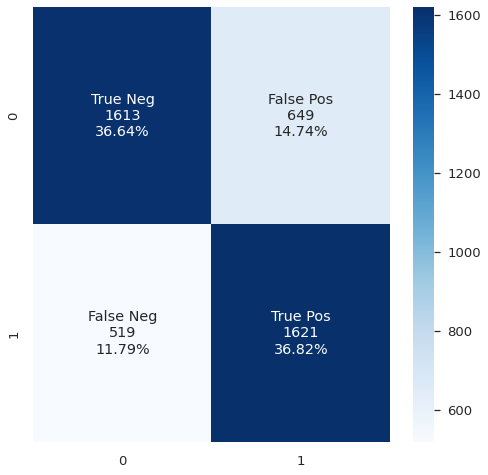

In [ ]:
fit_model_acc(LG_cf, sample_df2_X, sample_df2_y)

['sample_df2_X', 'sample_df2_y'] 데이터를 사용한 모델 LogisticRegressionCV 의 경우 test_size가 0.27일 때 0.729의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.27,0.729
0.33,0.7289
0.29,0.7289
0.16,0.7281
0.40,0.7279


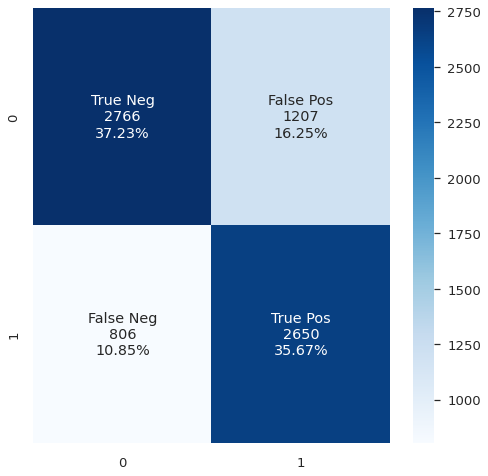

In [ ]:
fit_model_acc(LR_cv, sample_df2_X, sample_df2_y)

['sample_df4_X', 'sample_df4_y'] 데이터를 사용한 모델 CatBoostClassifier 의 경우 test_size가 0.24일 때 0.7454의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.24,0.7454
0.16,0.745
0.15,0.7442
0.20,0.7436
0.23,0.7436


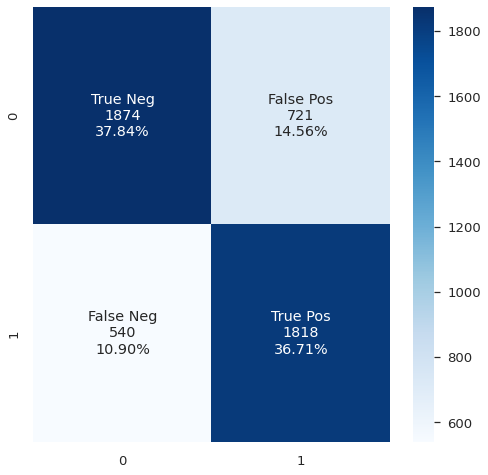

In [ ]:
fit_model_acc(CB_cf, sample_df4_X, sample_df4_y)

['sample_df4_X', 'sample_df4_y'] 데이터를 사용한 모델 XGBClassifier 의 경우 test_size가 0.24일 때 0.7458의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.24,0.7458
0.23,0.7438
0.22,0.743
0.26,0.7418
0.21,0.7413


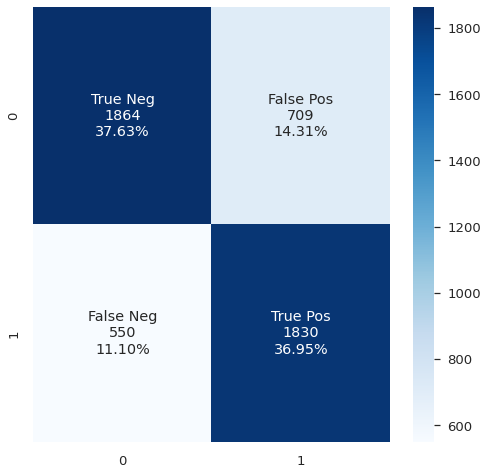

In [ ]:
fit_model_acc(XGB_cf, sample_df4_X, sample_df4_y)

['sample_df4_X', 'sample_df4_y'] 데이터를 사용한 모델 GradientBoostingClassifier 의 경우 test_size가 0.24일 때 0.7442의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.24,0.7442
0.22,0.7432
0.23,0.7429
0.15,0.7413
0.20,0.7412


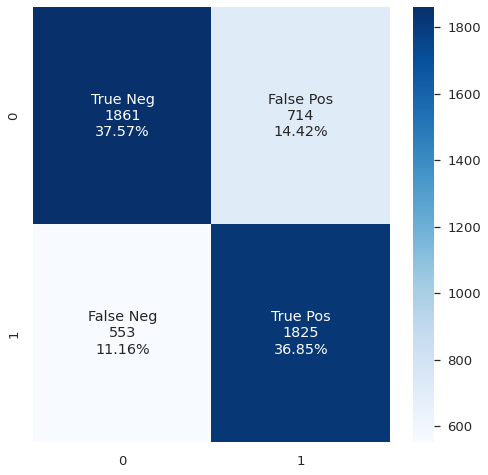

In [ ]:
fit_model_acc(GB_cf, sample_df4_X, sample_df4_y)

['sample_df4_X', 'sample_df4_y'] 데이터를 사용한 모델 LGBMClassifier 의 경우 test_size가 0.15일 때 0.7458의 정확도로 가장 높음
----------------------------------------


,ACC
test_size,
0.15,0.7458
0.17,0.7426
0.21,0.742
0.20,0.7417
0.26,0.7415


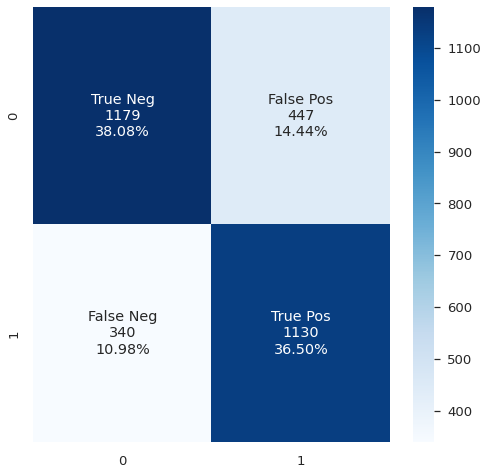

In [ ]:
fit_model_acc(LG_cf, sample_df4_X, sample_df4_y)